# EE4483 Mini Project (Option 2): Cats vs Dogs

Name: Melvin Kok Xinwei
Matriculation Number: U1820030C

## Overview
1. Loading data
2. Data processing
3. Model selection
4. Model training
5. Prediction

# Setup environment

In [1]:
import copy
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from pandas.core.common import flatten
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.cuda.is_available()
separator = os.path.sep

In [3]:
params = {
    # "model": "resnet50",
    # "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "n_epochs": 10,
    "image_size": 256,
    "dropout_rate": 0.5,
    "in_channels": 3,
    "num_classes": 2
}

# 1. Data exploration

Place `datasets` in same directory as notebook

In [4]:
# Define main directories
base_dir = "datasets"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [5]:
# Paths for training images
train_image_paths = []
train_classes = {}

for data_path in glob.glob(train_dir + separator + "*"):
    images = glob.glob(data_path + separator + "*")
    train_classes[data_path.split(separator)[-1]] = len(images)
    train_image_paths.append(images)

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

# Paths for validation images
validation_image_paths = []
validation_classes = {}

for data_path in glob.glob(validation_dir + separator + "*"):
    images = glob.glob(data_path + separator + "*")
    validation_classes[data_path.split(separator)[-1]] = len(images)
    validation_image_paths.append(images)

validation_image_paths = list(flatten(validation_image_paths))
random.shuffle(validation_image_paths)

# Paths for test images
test_image_paths = []
for data_path in glob.glob(test_dir + separator + "*"):
    # test_image_paths.append(glob.glob(data_path + separator + "*"))
    test_image_paths.append(data_path)

test_image_paths = list(flatten(test_image_paths))

print("train_image_path example: ", train_image_paths[0])
print("validation_image_path example: ", validation_image_paths[0])
print("test_image_path example: ", test_image_paths[0])

train_image_path example:  datasets\train\cat\cat.2524.jpg
validation_image_path example:  datasets\val\cat\cat.6958.jpg
test_image_path example:  datasets\test\1.jpg


In [6]:
for key, value in train_classes.items():
    print(f"Train class {key}, data size {value}")

for key, value in validation_classes.items():
    print(f"Validation class {key}, data size {value}")

print(f"Test size: {len(test_image_paths)}")

Train class cat, data size 10000
Train class dog, data size 10000
Validation class cat, data size 2500
Validation class dog, data size 2500
Test size: 500


# Loading data into Pytorch

In [7]:
# Class to index mappings

idx_to_class = {i:j for i, j in enumerate(train_classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

# Custom Dataset class
class CatDogDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split(separator)[-2]
        label = self.class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [8]:
# Get mean and std of dataset
# transform = transforms.Compose(
#     [
#         transforms.ToPILImage(),
#         transforms.RandomResizedCrop(params["image_size"]),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         # transforms.RandomApply([AddGaussianNoise(0., 1.)], p=0.5),
#     ]
# )

# dataset = CatDogDataset(train_image_paths, class_to_idx, transform)

# means = []
# vars = []
# for img, _ in tqdm(dataset):
#     means.append(torch.mean(img, [1, 2]))
#     vars.append(torch.var(img, [1, 2]))

# mean = torch.mean(torch.stack(means), 0)
# var = torch.mean(torch.stack(vars), 0)
# std = torch.sqrt(var)

# mean = mean.tolist()
# std = std.tolist()
# print(mean)
# print(std)

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

In [9]:
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(params["image_size"]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

validation_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        # transforms.Resize(356),
        transforms.Resize((params["image_size"], params["image_size"])),
        # transforms.CenterCrop(params["image_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [10]:
train_dataset = CatDogDataset(train_image_paths, class_to_idx, train_transform)
valid_dataset = CatDogDataset(validation_image_paths, class_to_idx, validation_transform)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=True)

loaders = {'train': train_loader, 'valid': valid_loader}

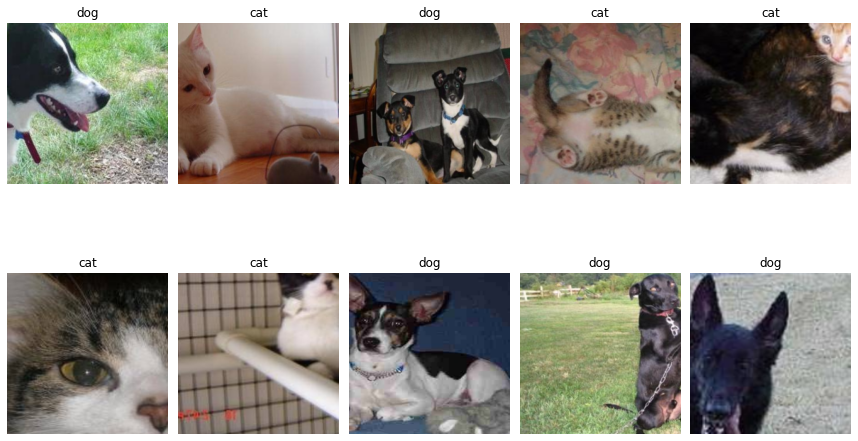

In [12]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img=False):

    dataset = copy.deepcopy(dataset)
    # we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(params["image_size"]),
            transforms.RandomHorizontalFlip(),
        ]
    )
    rows = samples // cols

    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()


visualize_augmentations(train_dataset, np.random.randint(
    1, len(train_image_paths)), random_img=True)

# 3. Model selection

In [13]:
model = torchvision.models.vgg19(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=params["dropout_rate"]),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=params["dropout_rate"]),
                                       torch.nn.Linear(4096, 2))

for index, param in enumerate(model.classifier.parameters()):
    if index == 6:
        param.requires_grad = True

model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=params["lr"])

In [16]:
train_losses = []
valid_losses = []
for epoch in range(params['n_epochs']):
    # Train
    train_loss = 0.0
    model.train()
    with tqdm(enumerate(train_loader), total=len(train_loader), unit="batch") as pbar:
        for step, (imgs, labels) in pbar:
            pbar.set_description(f"Epoch {epoch+1}/{params['n_epochs']}")

            imgs, labels = imgs.to(device), labels.to(device)
            log_preds = model(imgs)
            loss = loss_fn(log_preds, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss += ((1 / (step + 1)) * (loss.data.item() - train_loss))

            pbar.set_postfix(loss=loss.data.item())
    train_losses.append(train_loss)

    # Validation
    running_loss = 0
    actual_labels = []
    pred_labels = []
    model.eval()
    with tqdm(enumerate(valid_loader), total=len(valid_loader), unit="batch") as pbar:
        for step, (imgs, labels) in pbar:
            pbar.set_description(f"Epoch {epoch+1}/{params['n_epochs']}")  
            imgs, labels = imgs.to(device), labels.to(device)
            log_preds = model(imgs)
            loss = loss_fn(log_preds, labels)

            preds = torch.exp(log_preds)
            running_loss+=((1 / (step + 1)) * (loss.data.item() - running_loss))

            #calculate accuracy
            top_prob, top_class = preds.topk(1, dim=1)
            pred_labels+= list((top_class.view(-1)).cpu().numpy())
            actual_labels+= list(labels.cpu().numpy())

            pbar.set_postfix(loss=loss.data.item())

        correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
        total = len(valid_dataset)
        accuracy = correct / total

        tqdm.write('Epoch {} avg Valid loss: {:.3f}'.format(epoch + 1, running_loss))
        tqdm.write('Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n'.format(
            epoch + 1, accuracy, correct, total))

    valid_losses.append(running_loss)

    # if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss_fn,
    #         'train_transforms': transform,
    #         'test_transforms': transform,
    #         }, 'checkpoint.tar')

Epoch 1/10: 100%|██████████| 40/40 [00:46<00:00,  1.17s/batch, loss=0.347]


Epoch 1 avg Valid loss: 0.320
Epoch 1 Valid accuracy: 97.1% (4854 of 5000 right)



Epoch 2/10: 100%|██████████| 40/40 [00:43<00:00,  1.09s/batch, loss=0.0618]


Epoch 2 avg Valid loss: 0.150
Epoch 2 Valid accuracy: 97.5% (4875 of 5000 right)



Epoch 3/10: 100%|██████████| 40/40 [00:43<00:00,  1.08s/batch, loss=0.12]


Epoch 3 avg Valid loss: 0.096
Epoch 3 Valid accuracy: 97.6% (4882 of 5000 right)



Epoch 4/10: 100%|██████████| 40/40 [00:42<00:00,  1.06s/batch, loss=0.127]


Epoch 4 avg Valid loss: 0.073
Epoch 4 Valid accuracy: 97.9% (4894 of 5000 right)



Epoch 5/10: 100%|██████████| 40/40 [00:43<00:00,  1.09s/batch, loss=0.00284]


Epoch 5 avg Valid loss: 0.059
Epoch 5 Valid accuracy: 98.0% (4899 of 5000 right)



Epoch 6/10: 100%|██████████| 40/40 [00:43<00:00,  1.08s/batch, loss=0.0117]


Epoch 6 avg Valid loss: 0.052
Epoch 6 Valid accuracy: 98.0% (4901 of 5000 right)



Epoch 7/10: 100%|██████████| 40/40 [00:41<00:00,  1.03s/batch, loss=0.0154]


Epoch 7 avg Valid loss: 0.048
Epoch 7 Valid accuracy: 98.1% (4904 of 5000 right)



Epoch 8/10: 100%|██████████| 40/40 [00:42<00:00,  1.06s/batch, loss=0.0133]


Epoch 8 avg Valid loss: 0.045
Epoch 8 Valid accuracy: 98.2% (4912 of 5000 right)



Epoch 9/10: 100%|██████████| 40/40 [00:42<00:00,  1.05s/batch, loss=0.000392]


Epoch 9 avg Valid loss: 0.042
Epoch 9 Valid accuracy: 98.3% (4915 of 5000 right)



Epoch 10/10: 100%|██████████| 40/40 [00:42<00:00,  1.06s/batch, loss=0.144]

Epoch 10 avg Valid loss: 0.044
Epoch 10 Valid accuracy: 98.3% (4914 of 5000 right)



In [ ]:
torch.save(model.state_dict(), f"models/{params['lr']}_{params['image_size']}_{params['n_epochs']}_{params['dropout_rate']}.pth")

In [ ]:
model.load_state_dict(torch.load(f"models/{params['lr']}_{params['image_size']}_{params['n_epochs']}_{params['dropout_rate']}.pth"))
model.eval()